# Variational Autoencoder for pan-cancer gene expression

**Alexander Titus 2018** -- extended from Gregory Way 2017

This script trains and outputs results for a [variational autoencoder (VAE)](https://arxiv.org/abs/1312.6114)
applied to breast cancer methylation data.

A VAE aproximates the data generating function for the cancer data and learns the lower dimensional manifold a tumor occupies in methylation space. By compressing the methylation space into lower dimensional space, the VAE would, ideally, learn biological principles, such as cancer hallmark pathway activations, that help explain how tumors are similar and different. The VAE is also a generative model with a latent space that can be interpolated to observe transitions between cancer states.

The particular model trained in this notebook consists of methylation input (100,000 most variably methylated CpGs by median absolute deviation) compressed down into two length 100 vectors (mean and variance encoded spaces) which are made deterministic through the reparameterization trick of sampling an epsilon vector from the uniform distribution. The encoded layer is then decoded back to original 100,000 dimensions through a single reconstruction layer. Included is a layer of batch normalization in the encoding step to prevent dead nodes. The encoding scheme also uses relu activation while the decoder uses a sigmoid activation to enforce positive activations. All weights are glorot uniform initialized. 

Another trick used here to encourage manifold learning is _warm start_ as discussed in [Sonderby et al. 2016](https://arxiv.org/abs/1602.02282). With warm starts, we add a parameter _beta_, which controls the contribution of the KL divergence loss in the total VAE loss (reconstruction + (beta * KL)). In this setting, the model begins training deterministically as a vanilla autoencoder (_beta_ = 0) and slowly ramps up after each epoch linearly until _beta_ = 1. After a parameter sweep, we observed that kappa has little influence in training, therefore, we set  _kappa_ = 1, which is a full VAE.

Much of this script is inspired by the [keras variational_autoencoder.py example](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py)

## conda version 4.4.10
conda env create --force --file environment.yml

## activate environment
conda activate tybalt

In [1]:
pip install numpy pandas matplotlib seaborn tensorflow keras pydot graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pydot --upgrade

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Layer, Activation
from tensorflow.keras.layers import BatchNormalization
#from keras.layers.normalization import BatchNormalization
from keras.models import Model
from tensorflow.keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
import keras

import pydot
import graphviz
from keras.utils import plot_model
from keras_tqdm import TQDMNotebookCallback
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
#from keras.utils.vis_utils import model_to_dot

/Users/tyronemariano/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
print(keras.__version__)
print(tf.__version__)

3.5.0
2.17.0


In [5]:
%matplotlib inline
plt.style.use('seaborn-v0_8-notebook')

In [6]:
sns.set(style="white", color_codes=True)
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":15,"axes.labelsize":20,
                             'xtick.labelsize':14, 'ytick.labelsize':14})

## Load Functions and Classes

This will facilitate connections between layers and also custom hyperparameters

In [7]:
# Function for reparameterization trick to make model differentiable
def sampling(args):
    
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z

"""
class CustomVariationalLayer(Layer):
    
    #Define a custom layer that learns and performs the training
    #This function is borrowed from:
    #https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x
        
        """
        
class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    This function is borrowed from:
    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    """

    def __init__(self, beta, original_dim,encoder_model, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.beta = beta
        self.original_dim = original_dim
        self.encoder = encoder_model
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        # Assuming both inputs have the same shape
        output_shape = input_shape[0]  # Return the same shape as the first input
        return output_shape

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = self.original_dim * tf.keras.losses.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * tf.math.reduce_sum(1 + self.z_log_var_encoded - tf.math.square(self.z_mean_encoded) - 
                                             tf.math.exp(self.z_log_var_encoded), axis=-1)
        return tf.reduce_mean(reconstruction_loss + (self.beta * kl_loss))  # Use tf functions

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        self.z_mean_encoded, self.z_log_var_encoded = self.encoder(x)  # Assume 'encoder' is defined elsewhere
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss)
        # Return the first input (typically the encoded representation)
        return x

### Implementing Warm-up as described in Sonderby et al. LVAE

This is modified code from https://github.com/fchollet/keras/issues/2595

In [8]:
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [9]:
np.random.seed(123)

## Load Methylation Data

In [10]:
# BreastCancerMethylation_top100kMAD_cpg.csv file = https://app.box.com/s/xzh0vu2e85pxusflxt47434yfxqi4355
#methyl_file = os.path.join('data/raw', 'BreastCancerMethylation_top100kMAD_cpg.csv')
#methyl_file = os.path.join('data/raw', 'BreastCancerMethylation_top100kMAD_cpg.csv')
#methyl_df = pd.read_csv(methyl_file, index_col = 0, header  = 0)

#methyl_file = os.path.join('data/raw', 'BreastCancerMethylation_top100kMAD_cpg.csv')
methyl_df = pd.read_csv('~/Desktop/BreastCancerMethylation_top100kMAD_cpg.csv', index_col = 0, header  = 0)

print(methyl_df.shape)
methyl_df.head(2)

(1230, 100000)


,cg01682111,cg18391209,cg27260772,cg27363327,cg17882374,cg16620382,cg23357130,cg05528899,cg01893212,cg13885357,...,cg26340740,cg07552322,cg26966083,cg03222009,cg13058453,cg17525418,cg17584014,cg01617071,cg00678668,cg01986630
CpG,,,,,,,,,,,,,,,,,,,,,
7796806090_R04C01,0.148795,0.827165,0.07093,0.068544,0.951175,0.055168,0.044086,0.203048,0.566052,0.566779,...,0.752437,0.240496,0.701855,0.717532,0.603018,0.718762,0.689224,0.514234,0.649068,0.473050
6285633051_R04C01,0.819280,0.238459,0.17315,0.074701,0.443478,0.137893,0.612504,0.952400,0.626088,0.387909,...,0.797816,0.142233,0.684140,0.785218,0.522061,0.925992,0.657774,0.577316,0.718510,0.539516


In [11]:
methyl_df.head(10)

,cg01682111,cg18391209,cg27260772,cg27363327,cg17882374,cg16620382,cg23357130,cg05528899,cg01893212,cg13885357,...,cg26340740,cg07552322,cg26966083,cg03222009,cg13058453,cg17525418,cg17584014,cg01617071,cg00678668,cg01986630
CpG,,,,,,,,,,,,,,,,,,,,,
7796806090_R04C01,0.148795,0.827165,0.070930,0.068544,0.951175,0.055168,0.044086,0.203048,0.566052,0.566779,...,0.752437,0.240496,0.701855,0.717532,0.603018,0.718762,0.689224,0.514234,0.649068,0.473050
6285633051_R04C01,0.819280,0.238459,0.173150,0.074701,0.443478,0.137893,0.612504,0.952400,0.626088,0.387909,...,0.797816,0.142233,0.684140,0.785218,0.522061,0.925992,0.657774,0.577316,0.718510,0.539516
9993943017_R04C02,0.650826,0.880407,0.047947,0.289356,0.881477,0.591397,0.075619,0.402892,0.215336,0.231326,...,0.882816,0.434395,0.543037,0.773132,0.445141,0.711427,0.409403,0.758470,0.606913,0.851783
7796806090_R03C01,0.035875,0.830541,0.917678,0.042454,0.954357,0.027590,0.846287,0.944999,0.026760,0.429940,...,0.905686,0.332484,0.560664,0.687295,0.455923,0.851694,0.613663,0.499860,0.916871,0.902669
3999997079_R01C02,0.450423,0.842861,0.031449,0.070341,0.097155,0.063119,0.028255,0.942301,0.789728,0.121966,...,0.808625,0.463696,0.291677,0.835234,0.516774,0.847054,0.794826,0.743375,0.506338,0.753739
7796806055_R02C01,0.770123,0.802146,0.110602,0.121587,0.873710,0.094007,0.283905,0.474450,0.345917,0.202572,...,0.729903,0.269206,0.643681,0.725206,0.527352,0.898051,0.595403,0.435132,0.765707,0.562550
7796806109_R05C01,0.765392,0.251048,0.061159,0.109517,0.500501,0.225275,0.060325,0.415817,0.057751,0.042447,...,0.902006,0.316639,0.638063,0.570037,0.523097,0.708217,0.515078,0.662246,0.884126,0.814550
7796806090_R05C01,0.858135,0.217465,0.737122,0.711908,0.545919,0.831801,0.744905,0.395247,0.755492,0.064197,...,0.899662,0.179787,0.796012,0.762629,0.463218,0.874139,0.709964,0.701073,0.823975,0.826483
9283265058_R05C02,0.895007,0.216222,0.824580,0.601719,0.970117,0.793001,0.045754,0.512664,0.777678,0.031865,...,0.539628,0.154244,0.392271,0.799008,0.489610,0.664487,0.372536,0.712625,0.390483,0.800523


In [12]:
# Split 10% test set randomly
test_set_percent = 0.1
methyl_test_df = methyl_df.sample(frac=test_set_percent)
methyl_train_df = methyl_df.drop(methyl_test_df.index)

## Initialize variables and hyperparameters

In [13]:
# Set hyper parameters
original_dim = methyl_df.shape[1]
latent_dim = 100

batch_size = 50
epochs = 50
learning_rate = 0.0005 #not referred

epsilon_std = 1.0
#beta = tf.Variable(0)
beta = K.variable(0)
kappa = 1

## Encoder

In [14]:
# Input place holder for methylation data with specific input size
methyl_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections,
# batch norm, and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(methyl_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(methyl_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

## Decoder

In [15]:
# The decoding layer is much simpler with a single layer and sigmoid activation
decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
methyl_reconstruct = decoder_to_reconstruct(z)

## Connect the encoder and decoder to make the VAE

The `CustomVariationalLayer()` includes the VAE loss function (reconstruction + (beta * KL)), which is what will drive our model to learn an interpretable representation of gene expression space.

The VAE is compiled with an Adam optimizer and built-in custom loss function. The `loss_weights` parameter ensures beta is updated at each epoch end callback

In [16]:
adam = optimizers.Adam(learning_rate=0.0005)
#vae_layer = CustomVariationalLayer()([methyl_input, methyl_reconstruct])
encoder_model = Model(methyl_input, [z_mean_encoded, z_log_var_encoded])
#encoder_model = Model(methyl_input, z_mean_encoded)
vae_layer = CustomVariationalLayer(beta=beta, original_dim=original_dim, encoder_model=encoder_model)([methyl_input, methyl_reconstruct])
vae = Model(methyl_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

vae.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100000)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 100)       │ 10,000,100 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100)       │ 10,000,100 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100)       │        400 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100)       │        400 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 100)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 100)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 100)       │          0 │ activation[0][0], │
│                     │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100000)    │ 10,100,000 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ custom_variational… │ (None, 100000)    │ 20,001,000 │ input_layer[0][0… │
│ (CustomVariational… │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,101,000 (114.83 MB)

 Trainable params: 30,100,600 (114.82 MB)

 Non-trainable params: 400 (1.56 KB)

In [17]:
# Visualize the connections of the custom VAE model
#output_model_file = os.path.join('~/Desktop', 'onehidden_vae_architecture.png')
#plot_model(vae, to_file=output_model_file)

#SVG(model_to_dot(vae).create(prog='dot', format='svg'))

## Train the model

The training data is shuffled after every epoch and 10% of the data is heldout for calculating validation loss.

In [18]:
%%time
hist = vae.fit(np.array(methyl_train_df),
               shuffle=True,
               epochs=epochs,
               verbose=0,
               batch_size=batch_size,
               validation_data=(np.array(methyl_test_df), None),
               callbacks=[WarmUpCallback(beta, kappa)])
                          #TQDMNotebookCallback(leave_inner=True, leave_outer=True)])

CPU times: user 17min 35s, sys: 2min 54s, total: 20min 30s
Wall time: 3min 15s


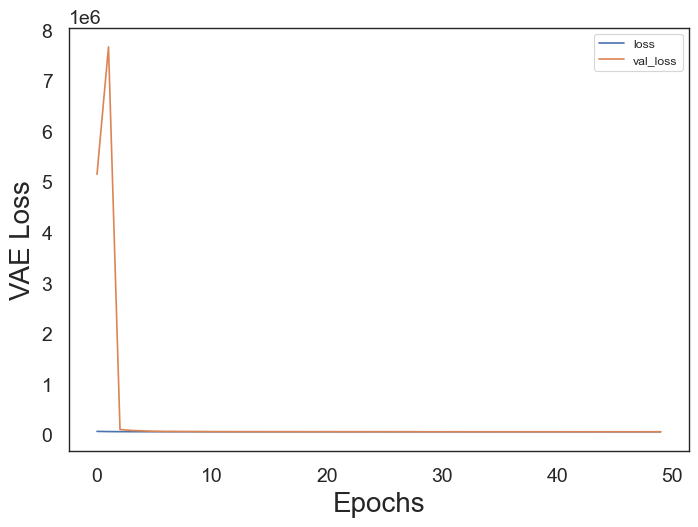

In [19]:
# Visualize training performance
history_df = pd.DataFrame(hist.history)
#hist_plot_file = os.path.join('~/Desktop', 'onehidden_vae_training.pdf')

home_dir = os.path.expanduser('~')

# Join the home directory with the desired file path
hist_plot_file = os.path.join(home_dir, 'Desktop', 'onehidden_vae_training.pdf')

ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

## Compile and output trained models

We are interested in:

1. The model to encode/compress the input methylation data
  * Can be possibly used to compress other tumors
2. The model to decode/decompress the latent space back into methylation space
  * This is our generative model
3. The latent space compression of all breast cancer samples
  * Non-linear reduced dimension representation of tumors can be used as features for various tasks
    * Supervised learning tasks predicting specific methylation events
    * Interpolating across this space to observe how methylation changes between two cancer states
4. The weights used to compress each latent node
  * Potentially indicate learned biology differentially activating tumors

### Encoder model

In [20]:
# Model to compress input
encoder = Model(methyl_input, z_mean_encoded)

In [21]:
# Encode methylation into the hidden/latent representation - and save output
encoded_methyl_df = encoder.predict_on_batch(methyl_df)
encoded_methyl_df = pd.DataFrame(encoded_methyl_df, index=methyl_df.index)

encoded_methyl_df.columns.name = 'sample_id'
encoded_methyl_df.columns = encoded_methyl_df.columns + 1
#encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_100k_2.tsv')
#encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_100k_3.tsv')
encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_100k_100.tsv')

encoded_methyl_df.to_csv(encoded_file, sep='\t')

### Decoder (generative) model

In [22]:
# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

## Save the encoder/decoder models for future investigation

In [23]:
encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_100k_2.hdf5')
decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_100k_2.hdf5')

#encoder.save(encoder_model_file)
#decoder.save(decoder_model_file)

##  Model Interpretation - Sanity Check


###  Observe the distribution of node activations.

We want to ensure that the model is learning a distribution of feature activations, and not zeroing out features.

In [24]:
# What are the most and least activated nodes
sum_node_activity = encoded_methyl_df.sum(axis=0).sort_values(ascending=False)

# Top 10 most active nodes
print(sum_node_activity.head(10))

# Bottom 10 least active nodes
sum_node_activity.tail(10)

sample_id
4      1839.021240
30     1759.045776
90     1721.190186
71     1682.852783
94     1591.224365
100    1458.127075
23     1411.496338
16     1380.844604
64     1371.243164
89     1367.458862
dtype: float32


sample_id
1     371.268036
28    370.786621
37    331.550690
95    330.520660
50    291.434509
87    263.637390
42    256.995026
98    234.491058
38    234.246918
83    193.839172
dtype: float32

sample_id
4     1839.021240
30    1759.045776
90    1721.190186
71    1682.852783
94    1591.224365
         ...     
87     263.637390
42     256.995026
98     234.491058
38     234.246918
83     193.839172
Length: 100, dtype: float32

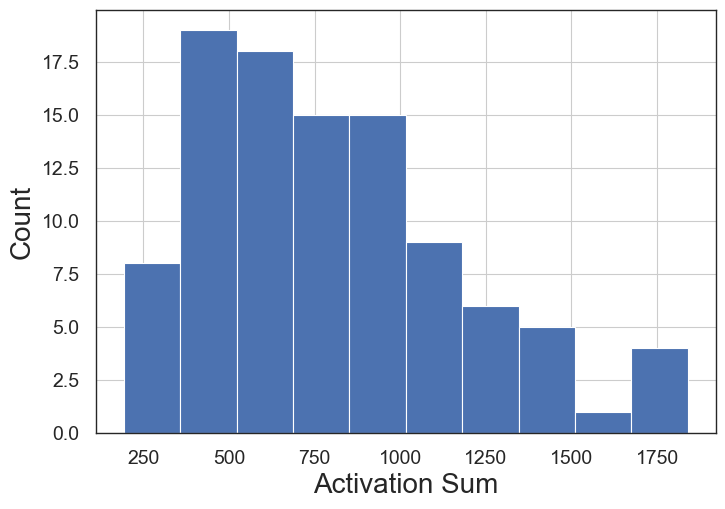

In [25]:
# Histogram of node activity for all 100 latent features
sum_node_activity.hist()
plt.xlabel('Activation Sum')
plt.ylabel('Count');
sum_node_activity

What does an example distribution of two latent features look like?

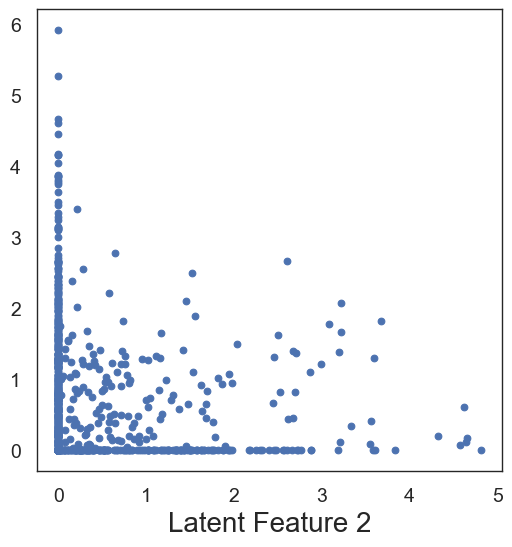

In [26]:
# Example of node activation distribution for the first two latent features
plt.figure(figsize=(6, 6))
plt.scatter(encoded_methyl_df.iloc[:, 0], encoded_methyl_df.iloc[:, 2])
plt.xlabel('Latent Feature 1')
plt.xlabel('Latent Feature 2');

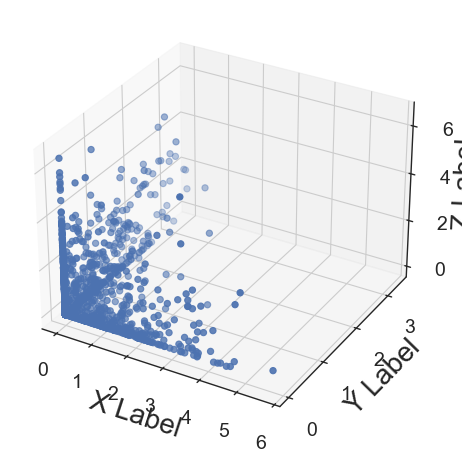

In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = encoded_methyl_df.iloc[:, 62]
ys = encoded_methyl_df.iloc[:, 36]
zs = encoded_methyl_df.iloc[:, 21]
ax.scatter(xs, ys, zs)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

###  Observe reconstruction fidelity

In [28]:
# How well does the model reconstruct the input methylation data
input_methyl_reconstruct = decoder.predict(np.array(encoded_methyl_df))
input_methyl_reconstruct = pd.DataFrame(input_methyl_reconstruct, index=methyl_df.index,
                                        columns=methyl_df.columns)
input_methyl_reconstruct.head(2)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,cg01682111,cg18391209,cg27260772,cg27363327,cg17882374,cg16620382,cg23357130,cg05528899,cg01893212,cg13885357,...,cg26340740,cg07552322,cg26966083,cg03222009,cg13058453,cg17525418,cg17584014,cg01617071,cg00678668,cg01986630
CpG,,,,,,,,,,,,,,,,,,,,,
7796806090_R04C01,0.264489,0.500698,0.364038,0.197003,0.816685,0.215934,0.242865,0.621324,0.163055,0.301513,...,0.728349,0.217394,0.591859,0.688948,0.484270,0.811596,0.572860,0.511175,0.790883,0.542627
6285633051_R04C01,0.509578,0.502445,0.292124,0.358310,0.504345,0.376456,0.286136,0.565321,0.352667,0.398219,...,0.759277,0.190360,0.596896,0.766515,0.477598,0.833814,0.545892,0.576590,0.779154,0.595270


In [29]:
reconstruction_fidelity = methyl_df - input_methyl_reconstruct

cpg_mean = reconstruction_fidelity.mean(axis=0)
cpg_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(methyl_df.shape[0])
cpg_summary = pd.DataFrame([cpg_mean, cpg_abssum], index=['CpG mean', 'CpG abs(sum)']).T
cpg_summary.sort_values(by='CpG abs(sum)', ascending=False).head()

,CpG mean,CpG abs(sum)
cg18391209,-0.024562,0.298099
cg05528899,0.027919,0.278944
cg27586797,0.027059,0.272656
cg04798314,-0.000871,0.264695
cg24506221,-0.024121,0.263796


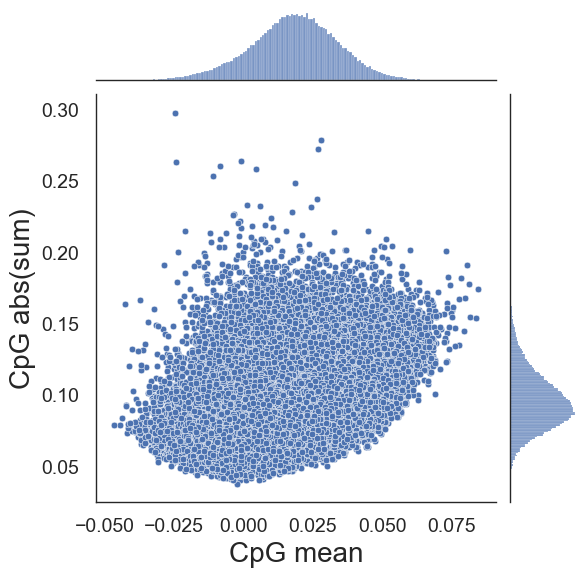

In [30]:
# Mean of cpg reconstruction vs. absolute reconstructed difference per sample
g = sns.jointplot(data=cpg_summary, x='CpG mean', y='CpG abs(sum)');